### Finetuning BERT base on SST2, IMDb, Yelp Dataset all at once 
The preprocessing functions defined in the `Preprocessing SST2, IMDb, Yelp Datasets.ipynb` jupyter notebook were used.

In [21]:
import torch
import numpy as np
import pandas as pd 
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers import AutoTokenizer, BertConfig
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from datasets import load_dataset, load_metric 
import datasets 
import random
import matplotlib.pyplot as plt
import evaluate
import json
''' Taking a pretrained BERT (transformer-based) model and fine-tuning it on SST2 Dataset '''

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [2]:
### Tokenizer to preprocess the input before feeding into the model
seq_len = 128
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len)

In [3]:
sst2_dataset = load_dataset("sst2")
imdb_dataset = load_dataset("imdb")
yelp_dataset = load_dataset('yelp_review_full')

Found cached dataset sst2 (/home/weiming/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset imdb (/home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset yelp_review_full (/home/weiming/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

### SST2 Preprocessing
SST2 contains the column "sentence", "label", "idx" while IMDb and Yelp contains the column "text" and "label". 

We convert "sentence" to "text" for SST2 and remove the "idx" column. 

In [4]:
# Preprocessing the data - converting words into vectors using tokenizers
def preprocess_function(examples):
    return tokenizer(examples["sentence"],  max_length=seq_len, padding = "max_length", truncation=True,)


sst2_dataset = sst2_dataset.map(preprocess_function, batched=True)
sst2_dataset = sst2_dataset.rename_column("sentence", "text")
sst2_dataset = sst2_dataset.remove_columns(['idx'])

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-5fd88f9299d62c43.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-a7a27b12044e9a1b.arrow


### IMDb Preprocessing

The class labels of IMDb dataset is 'neg' and 'pos' while the class labels of SST-2 dataset is 'negative' and 'positive'. In order to concantenate both datasets together, we need to standardize the naming.

In [5]:
### Removing <br /><br /> from the dataset
def preprocess_function_1(examples):
    for i in range(len(examples['text'])):
        examples['text'][i] = examples['text'][i].replace('<br /><br />', " ")
    return examples

### Tokenizing words into integer for embedding layer in BERT
def preprocess_function_2(examples):
    return tokenizer(examples['text'],max_length=seq_len, padding = "max_length",truncation=True)


imdb_new_features = imdb_dataset["train"].features.copy()
imdb_new_features["label"] = datasets.ClassLabel(names=["negative", "positive"])
imdb_dataset["train"] = imdb_dataset["train"].cast(imdb_new_features)

imdb_new_features = imdb_dataset["test"].features.copy()
imdb_new_features["label"] = datasets.ClassLabel(names=["negative", "positive"])
imdb_dataset["test"] = imdb_dataset["test"].cast(imdb_new_features)

imdb_dataset = imdb_dataset.map(preprocess_function_1, batched=True)
imdb_dataset = imdb_dataset.map(preprocess_function_2, batched=True)

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-84ec0b414a0dbdd7.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-8922a968289d99de.arrow


  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

### Discarding 3-Star Review from Yelp, Setting 1/2-Star as Negative Sentiment, Setting 4/5-Star as Positive Sentiment

In [6]:
yelp_dataset = load_dataset('yelp_review_full')

print("-------------Before Preprocessing---------------")
print("Mapping of Labels for Yelp Training Dataset")
for i in range(yelp_dataset['train'].features['label'].num_classes):
    print(f"{i}: {yelp_dataset['train'].features['label'].int2str(i)}")

print()

print("Mapping of Labels for Yelp Validation Dataset")
for i in range(yelp_dataset['test'].features['label'].num_classes):
    print(f"{i}: {yelp_dataset['test'].features['label'].int2str(i)}")
    

### Converting Yelp Dataset into Pandas Dataframe
df_train = pd.DataFrame(yelp_dataset["train"])
df_test = pd.DataFrame(yelp_dataset["test"])

### Remove 3-Star Labels
df_train = df_train[df_train.label != 2]
df_test = df_test[df_test.label != 2]

### Set 1/2-Star Labels as 0 (Negative)
df_train['label'].loc[(df_train['label'] == 0) | (df_train['label'] == 1)] = 0
df_train['label'].loc[(df_train['label'] == 3) | (df_train['label'] == 4)] = 1

### Set 4/5-Star Labels as 0 (Positive)
df_test['label'].loc[(df_test['label'] == 0) | (df_test['label'] == 1)] = 0
df_test['label'].loc[(df_test['label'] == 3) | (df_test['label'] == 4)] = 1

### Convert back to Dataset from pandas Dataframe
yelp_ds_train = datasets.Dataset.from_pandas(df_train)
yelp_ds_train = yelp_ds_train.remove_columns('__index_level_0__')
yelp_new_features = yelp_ds_train.features.copy()
yelp_new_features["label"] = datasets.ClassLabel(names=["negative", "positive"])
yelp_ds_train = yelp_ds_train.cast(yelp_new_features)

yelp_ds_test = datasets.Dataset.from_pandas(df_test)
yelp_ds_test = yelp_ds_test.remove_columns('__index_level_0__')
yelp_new_features = yelp_ds_test.features.copy()
yelp_new_features["label"] = datasets.ClassLabel(names=["negative", "positive"])
yelp_ds_test = yelp_ds_test.cast(yelp_new_features)

yelp_dataset = datasets.DatasetDict()
yelp_dataset["train"] = yelp_ds_train
yelp_dataset["test"] = yelp_ds_test

print("-------------After Preprocessing---------------")
print("Mapping of Labels for Yelp Training Dataset")
for i in range(yelp_dataset['train'].features['label'].num_classes):
    print(f"{i}: {yelp_dataset['train'].features['label'].int2str(i)}")

print()

print("Mapping of Labels for Yelp Validation Dataset")
for i in range(yelp_dataset['test'].features['label'].num_classes):
    print(f"{i}: {yelp_dataset['test'].features['label'].int2str(i)}")
    

Found cached dataset yelp_review_full (/home/weiming/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

-------------Before Preprocessing---------------
Mapping of Labels for Yelp Training Dataset
0: 1 star
1: 2 star
2: 3 stars
3: 4 stars
4: 5 stars

Mapping of Labels for Yelp Validation Dataset
0: 1 star
1: 2 star
2: 3 stars
3: 4 stars
4: 5 stars


/tmp/ipykernel_1005934/2609836007.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['label'].loc[(df_train['label'] == 3) | (df_train['label'] == 4)] = 1
/tmp/ipykernel_1005934/2609836007.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['label'].loc[(df_test['label'] == 3) | (df_test['label'] == 4)] = 1


Casting the dataset:   0%|          | 0/52 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

-------------After Preprocessing---------------
Mapping of Labels for Yelp Training Dataset
0: negative
1: positive

Mapping of Labels for Yelp Validation Dataset
0: negative
1: positive


### Yelp Further Preprocessing

In [7]:
### Removing '\\n' and replacing \\" with " from the dataset 
def preprocess_function_1(examples):
    for i in range(len(examples['text'])):
        examples['text'][i] = examples['text'][i].replace('\\n', " ")
        examples['text'][i] = examples['text'][i].replace('\\"', '"')

    return examples

### Tokenizing words into integer for embedding layer in BERT
seq_len = 128
def preprocess_function_2(examples):
    return tokenizer(examples['text'],max_length=seq_len, padding = "max_length",truncation=True)    
    

yelp_dataset = yelp_dataset.map(preprocess_function_1, batched=True)
yelp_dataset = yelp_dataset.map(preprocess_function_2, batched=True)

  0%|          | 0/520 [00:00<?, ?ba/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/520 [00:00<?, ?ba/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

In [8]:
print(sst2_dataset)
print(imdb_dataset)
print(yelp_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1821
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        nu

In [10]:
### Concatenate SST2, IMDb, Yelp Dataset into a single dataset
train_ds = datasets.concatenate_datasets([sst2_dataset['train'], imdb_dataset['train'], yelp_dataset['train']])
val_ds = datasets.concatenate_datasets([sst2_dataset['validation'], imdb_dataset['test'], yelp_dataset['test']])

print(train_ds)
print(val_ds)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 612349
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 65872
})


In [13]:
print("Mapping of Labels for Training Dataset")
for i in range(train_ds.features['label'].num_classes):
    print(f"{i}: {train_ds.features['label'].int2str(i)}")

print()

print("Mapping of Labels for Validation Dataset")
for i in range(val_ds.features['label'].num_classes):
    print(f"{i}: {val_ds.features['label'].int2str(i)}")
    

Mapping of Labels for Training Dataset
0: negative
1: positive

Mapping of Labels for Validation Dataset
0: negative
1: positive


Min Seq Length (Train): 1
Max Seq Length (Train): 2460
Min Seq Length (Validation): 1
Max Seq Length (Validation): 2235


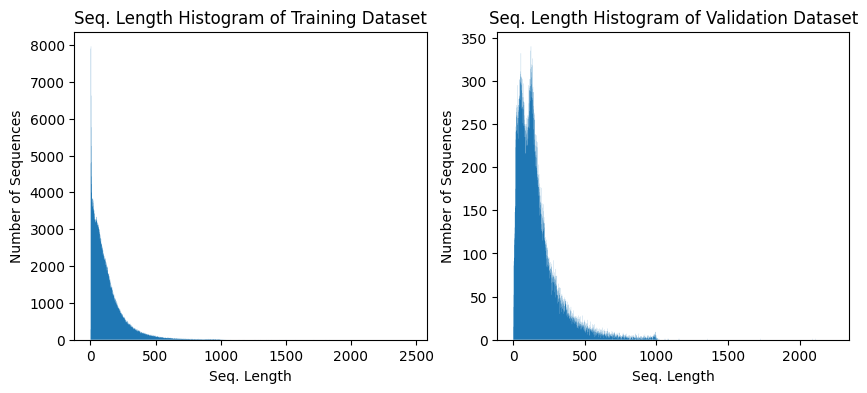

In [14]:
list_of_seq_len_train = []
list_of_seq_len_val = []
for seq in train_ds["text"]:
    # For each sequence, count how many words are there
    list_of_seq_len_train.append(len(seq.split(" ")))

for seq in val_ds["text"]:
    # For each sequence, count how many words are there
    list_of_seq_len_val.append(len(seq.split(" ")))
    
print(f"\
Min Seq Length (Train): {min(list_of_seq_len_train)}\n\
Max Seq Length (Train): {max(list_of_seq_len_train)}\n\
Min Seq Length (Validation): {min(list_of_seq_len_val)}\n\
Max Seq Length (Validation): {max(list_of_seq_len_val)}\
")

bins_train = np.arange(0, max(list_of_seq_len_train))
seq_len_hist_train, bins_train = np.histogram(list_of_seq_len_train, bins_train)

bins_val = np.arange(0, max(list_of_seq_len_val))
seq_len_hist_val, bins_val = np.histogram(list_of_seq_len_val, bins_val)

f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))

ax[0].stairs(seq_len_hist_train, bins_train, fill=True)
ax[0].set_xlabel("Seq. Length")
ax[0].set_ylabel("Number of Sequences")
ax[0].set_title("Seq. Length Histogram of Training Dataset")

ax[1].stairs(seq_len_hist_val, bins_val, fill=True)
ax[1].set_xlabel("Seq. Length")
ax[1].set_ylabel("Number of Sequences")
ax[1].set_title("Seq. Length Histogram of Validation Dataset")
plt.show()

### Finetuning BERT Base Uncased Model on Combined Dataset

In [16]:
def compute_metrics(eval_preds):
    metric = load_metric("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

class CustomTrainer(Trainer):
    def _maybe_log_save_evaluate(self, tr_loss, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log:

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss
            
            
            logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["accuracy"] = self.predict(test_dataset=self.train_dataset, metric_key_prefix="train").metrics['train_accuracy']
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
            self._report_to_hp_search(trial, epoch, metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)


In [17]:
### Freeze all parameters from embedding layer to enc_layers_to_freeze layers
def freeze_bert_layers(model, enc_layers_to_freeze):
    # Freeze Embedding Layer
    for name, param in model.named_parameters():
        if "embeddings" in name:
            param.requires_grad = False
            
    # Freeze encoder layers from the encoder layer closest to the embedding layer
    for i in range(enc_layers_to_freeze):
        for name, param in model.named_parameters():
            if f"layer.{i}." in name:
                param.requires_grad = False
                
    return model

### Display all unfrozen parameters - sanity check
def print_unfrozen_layers(model):
    print("--------------Unfrozen Parameters--------------")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print(name)

In [22]:
print(f"----Training BERT Base on Combined Dataset----")

### Number of Epochs
epoch_no = 10
### Learning Rate
learning_rate = 2e-5
### Adjust the batch size to avoid out-of-memory errors
batch_size = 32 
### Select random seed for finetuning
seed = 0
### Dropout Probability
dropout_prob = 0.2
### Number of encoder layers frozen
num_encoder_freeze = 2

### Define what pre-trained model checkpoint you want to use 
### Different pretrained models are available
### E.g. ['bert-base-uncased', 'distilbert-base-uncased', 'distilroberta', 'roberta-base',...]
### Different models have different training procedure and architecture and hence different performance
model_checkpoint = "bert-base-uncased"

### Tokenizer to preprocess the input before feeding into the model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len)

### 2 labels - 0 (Negative) or 1 (Positive)
num_labels = 2

### Using pretrained bert-base-uncased for Sentiment Classification
### Classification dropout probability will follow hidden dropout probability by default
config = BertConfig(hidden_dropout_prob = dropout_prob, attention_probs_dropout_prob=dropout_prob, num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
print(f"Pretrained Model for Combined Task: {model_checkpoint}")

### Freeze embedding layer and varying number of encoeder layers to prevent overfitting
model = freeze_bert_layers(model, num_encoder_freeze) 
print_unfrozen_layers(model)

### Introduce Early Stopping
earlystopping = EarlyStoppingCallback(early_stopping_patience=3)

### ---------------Define arguments for training---------------
###`TrainingArguments` is a class that contains all the attributes to customize 
### the training. It requires one folder name, which will be used to save the checkpoints 
### of the model, and all other arguments are optional:
training_args = TrainingArguments(
    f"./BERT-Combined-{seed}", #Creates a directory named as provided
    evaluation_strategy = "epoch", # Evaluate every epoch
    save_strategy = "epoch", # Save every epoch
    logging_strategy = "epoch", # Log every epoch
    save_total_limit = 1, # Only save one epoch data (the best one)
    learning_rate=learning_rate, # Learning rate - typically 2e-5 is used
    per_device_train_batch_size=batch_size, # Training Batch Size
    per_device_eval_batch_size=batch_size, # Validation Batch Size
    num_train_epochs=epoch_no, # Number of Epochs
    weight_decay=0.01, #Weight regularization
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy", # Criteria for "Best" model 
    optim="adamw_torch", #Optimizer
    warmup_ratio = 0.1, 
    seed=seed
)


trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=train_ds, # Train dataset
    eval_dataset=val_ds, # Val dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[earlystopping]
)

# Call trainer.train to start training
trainer.train()

----Training BERT Base on Combined Dataset----


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Pretrained Model for Combined Task: bert-base-uncased
--------------Unfrozen Parameters--------------
bert.encoder.layer.2.attention.self.query.weight
bert.encoder.layer.2.attention.self.query.bias
bert.encoder.layer.2.attention.self.key.weight
bert.encoder.layer.2.attention.self.key.bias
bert.encoder.layer.2.attention.self.value.weight
bert.encoder.layer.2.attention.self.value.bias
bert.encoder.layer.2.attention.output.dense.weight
bert.encoder.layer.2.attention.output.dense.bias
bert.encoder.layer.2.attention.output.LayerNorm.weight
bert.encoder.layer.2.attention.output.LayerNorm.bias
bert.encoder.layer.2.intermediate.dense.weight
bert.encoder.layer.2.intermediate.dense.bias
bert.encoder.layer.2.output.dense.weight
bert.encoder.layer.2.output.dense.bias
bert.encoder.layer.2.output.LayerNorm.weight
bert.encoder.layer.2.output.LayerNorm.bias
bert.encoder.layer.3.attention.self.query.weight
bert.encoder.layer.3.attention.self.query.bias
bert.encoder.layer.3.attention.self.key.weight
ber

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 612349
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 191360
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Plotting Training and Validation Loss and Accuracy Curves

In [24]:
### Function to extract training history from json file           
def get_history(filename):
    num_epochs_trained = 0
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    f = open(filename, "r")
    history = json.load(f)['log_history']
    
    for i in range(0, len(history), 2):
        num_epochs_trained += 1
        # Train 
        train_loss_list.append(history[i]['loss'])
        train_acc_list.append(history[i]['accuracy'])
        
        # Validation
        val_loss_list.append(history[i + 1]['eval_loss'])
        val_acc_list.append(history[i + 1]['eval_accuracy'])
    
    return num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list

Text(0.5, 1.0, 'Training vs Validation Accuracy')

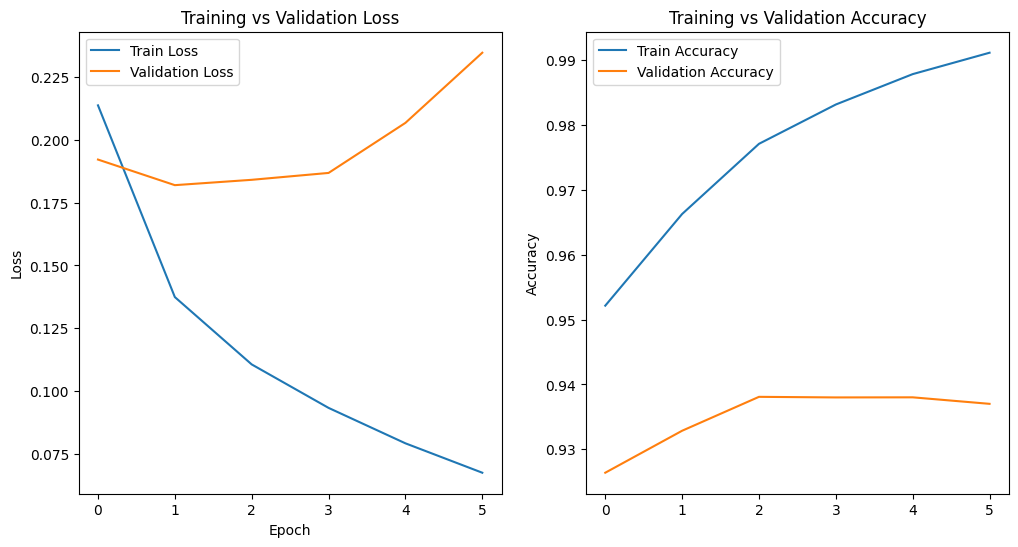

In [25]:
# num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list = get_history("./BERT-Combined-0/checkpoint-7820/trainer_state.json")
num_epochs_trained, train_loss_list, train_acc_list, val_loss_list, val_acc_list = get_history("/home/weiming/Desktop/Untitled Folder/CE4042/trainer_state.json")

epoch_list = [i for i in range(num_epochs_trained)]
_, ax = plt.subplots(nrows = 1, ncols=2, figsize=(12,6))
ax[0].plot(epoch_list, train_loss_list)
ax[0].plot(epoch_list, val_loss_list)
ax[0].legend(["Train Loss", "Validation Loss"])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training vs Validation Loss")

ax[1].plot(epoch_list, train_acc_list)
ax[1].plot(epoch_list, val_acc_list)
ax[1].legend(["Train Accuracy", "Validation Accuracy"])
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training vs Validation Accuracy")